# Classical Methods

In [1]:
import os
import cv2
import random
import itertools
import numpy as np
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

from torch.utils.data import ConcatDataset, Dataset, DataLoader, random_split

import torch

In [2]:
SAVE_PATH = "./"

TRAIN_TEST_SPLIT = (0.8, 0.1) # remaining parts will be test
DIRECTORY_PATH = "/home/mericdemirors/Desktop/TUD_lectures/DLMI/project/project_capsule_dataset"

THRESHOLD = 0.5 # predictions bigger than threshold will be counted as bleeding prediction, and lower ones will be healthy prediction

## Decision Function

In [3]:
class BleedDataset(Dataset):
    def __init__(self, root_dir, image_read_func="RGB"):
        self.root_dir = root_dir
        self.bleeding_dir = os.path.join(root_dir, "bleeding")
        self.healthy_dir = os.path.join(root_dir, "healthy")

        # get image paths
        self.x = [os.path.join(self.bleeding_dir, p) for p in os.listdir(self.bleeding_dir)] + [os.path.join(self.healthy_dir, p) for p in os.listdir(self.healthy_dir)]
        
        # get image labels, bleeding=1, healthy=0
        self.y = [1 for _ in os.listdir(self.bleeding_dir)] + [0 for _ in os.listdir(self.healthy_dir)]
        self.num_samples = len(os.listdir(self.bleeding_dir)) + len(os.listdir(self.healthy_dir))

        # set up the function to use for image reading
        # different reading functions can be written and used with this structure
        if image_read_func == "RGB":
            self.image_read_function = self.read_RGB
        elif image_read_func == "gray":
            self.image_read_function = self.read_gray
        else:
            print("Wrong image_read_func parameter")

    def __len__(self):
        return self.num_samples

    def read_RGB(self, idx):
        path = self.x[idx]
        label = self.y[idx]
        
        image = cv2.imread(path)
        image = image[32:544, 32:544] # cropping image to get rid of the black borders
        image[:48,:48] = [0,0,0] # painting the upper left corner if there is a gray square
        image[:31, 452:] = [0,0,0] # painting the upper right corner if there is white text parts
        image = np.transpose(image, [2,0,1]) # adjust the axises into the pytorch dimensions of [B, C, W, H]

        return image, label
    
    def read_gray(self, idx):
        path = self.x[idx]
        label = self.y[idx]
        
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        image = image[32:544, 32:544] # cropping image to get rid of the black borders
        image[:48,:48] = 0 # painting the upper left corner if there is a gray square
        image[:31, 452:] = 0 # painting the upper right corner if there is white text parts
        image = image[np.newaxis, ...] # adjust the axises into the pytorch dimensions of [B, C, W, H]
        
        return image, label

    def __getitem__(self, idx):
        image, label = self.image_read_function(idx)
        return image, label

In [4]:
### ---|---|---|---|---|---|---|---|---|---|--- DATASET SPLIT ---|---|---|---|---|---|---|---|---|---|--- ###
dataset = BleedDataset(DIRECTORY_PATH, image_read_func="RGB")

train_size = int(TRAIN_TEST_SPLIT[0] * len(dataset))
test_size = int(TRAIN_TEST_SPLIT[1] * len(dataset))
validation_size = len(dataset) - train_size - test_size

torch.manual_seed(0) # setting the seed to 0 so dataset split is same for every run
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
train_validation_dataset = ConcatDataset([train_dataset, validation_dataset])

train_validation_dataloader = DataLoader(train_validation_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
labels = [l.item() for (_,l) in tqdm(train_validation_dataloader)]

## Creating Decision Function

In [6]:
def torch_tensor_to_RGB_numpy(image):
    image = np.transpose(image, (1, 2, 0))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image

def function(image, parameter1, parameter2, parameter3):
    image = torch_tensor_to_RGB_numpy(image)
    
    red_multiplier = parameter1
    window_size = parameter2
    percentile = parameter3

    # Extract the red channel
    red_channel = image[:, :, 0]

    # Calculate the redness score for each pixel
    # Redness score is defined as R - (G + B)/2
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]
    redness_score = red_channel * red_multiplier - (green_channel + blue_channel)

    # Ensure no negative values (clipping to 0)
    redness_score = np.maximum(redness_score, 0)

    # Find the top 10% reddish pixel values
    threshold = np.percentile(redness_score, 100-percentile)
    high_red_indices = np.where(redness_score >= threshold)

    # Initialize variables for the best score and coordinates
    max_score = 0
    best_coords = (0, 0)

    # Calculate window scores only around high redness indices
    h, w = redness_score.shape
    for y, x in zip(*high_red_indices):
        # Define the top-left corner of the window
        top_left_y = max(0, y - window_size // 2)
        top_left_x = max(0, x - window_size // 2)

        # Define the bottom-right corner of the window
        bottom_right_y = min(h, top_left_y + window_size)
        bottom_right_x = min(w, top_left_x + window_size)

        # Extract the window and calculate its redness score
        window = redness_score[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
        score = np.sum(window)

        if score > max_score:
            max_score = score
            best_coords = (top_left_y, top_left_x)

    return max_score

decision_function = function

In [117]:
def find_reddish_area(image, window_size, red_multiplier, green_multiplier, blue_multiplier, percentile):
    image_rgb = image.astype(np.float32)

    redness_score = image_rgb[:, :, 0] * red_multiplier + image_rgb[:, :, 1] * green_multiplier + image_rgb[:, :, 2] * blue_multiplier

    # Find the top % reddish pixel values
    threshold = np.percentile(redness_score, 100-percentile)
    high_red_indices = np.where(redness_score >= threshold)

    # Initialize variables for the best score and coordinates
    max_score = -np.inf
    best_coords = (0, 0)

    # Calculate window scores only around high redness indices
    h, w = redness_score.shape
    for row, column in zip(*high_red_indices):
        # Define the top-left corner of the window
        top_left_row = max(0, row - window_size // 2)
        top_left_column = max(0, column - window_size // 2)

        # Define the bottom-right corner of the window
        bottom_right_row = min(h, top_left_row + window_size)
        bottom_right_column = min(w, top_left_column + window_size)

        # Extract the window and calculate its redness score
        window = redness_score[top_left_row:bottom_right_row, top_left_column:bottom_right_column]
        score = np.sum(window)

        if score > max_score:
            max_score = score
            best_coords = (row, column)
    
    # Highlight the most reddish area on the image
    image_rgb = image_rgb.astype(np.uint8)
    
    left_upper_column_row = [max(0, best_coords[1] - window_size//2), max(0, best_coords[0] - window_size//2)]
    right_lower_column_row = [min(w, best_coords[1] + window_size//2), min(h, best_coords[0] + window_size//2)]
    cv2.rectangle(image_rgb, left_upper_column_row, right_lower_column_row, (0, 255, 0), 2)
    
    return (image_rgb, max_score)

    plt.imshow(image_rgb)
    plt.show()
    
    return image_rgb, best_coords, max_score

post_process = find_reddish_area
post_process_parameters = (20, 4, -3, -3, 5)
# image_rgb = torch_tensor_to_RGB_numpy(dataset[5][0])
# image_rgb, best_coords, max_score = find_reddish_area(image=image_rgb,
#                                                     window_size=20,
#                                                     red_multiplier=4,
#                                                     green_multiplier=-3,
#                                                     blue_multiplier=-3,
#                                                     percentile=5)

In [105]:
decision_function_path = os.path.join(SAVE_PATH, f"{decision_function.__name__}_{datetime.now().strftime('on_%m.%d._at_%H:%M:%S')}")
os.makedirs(decision_function_path)

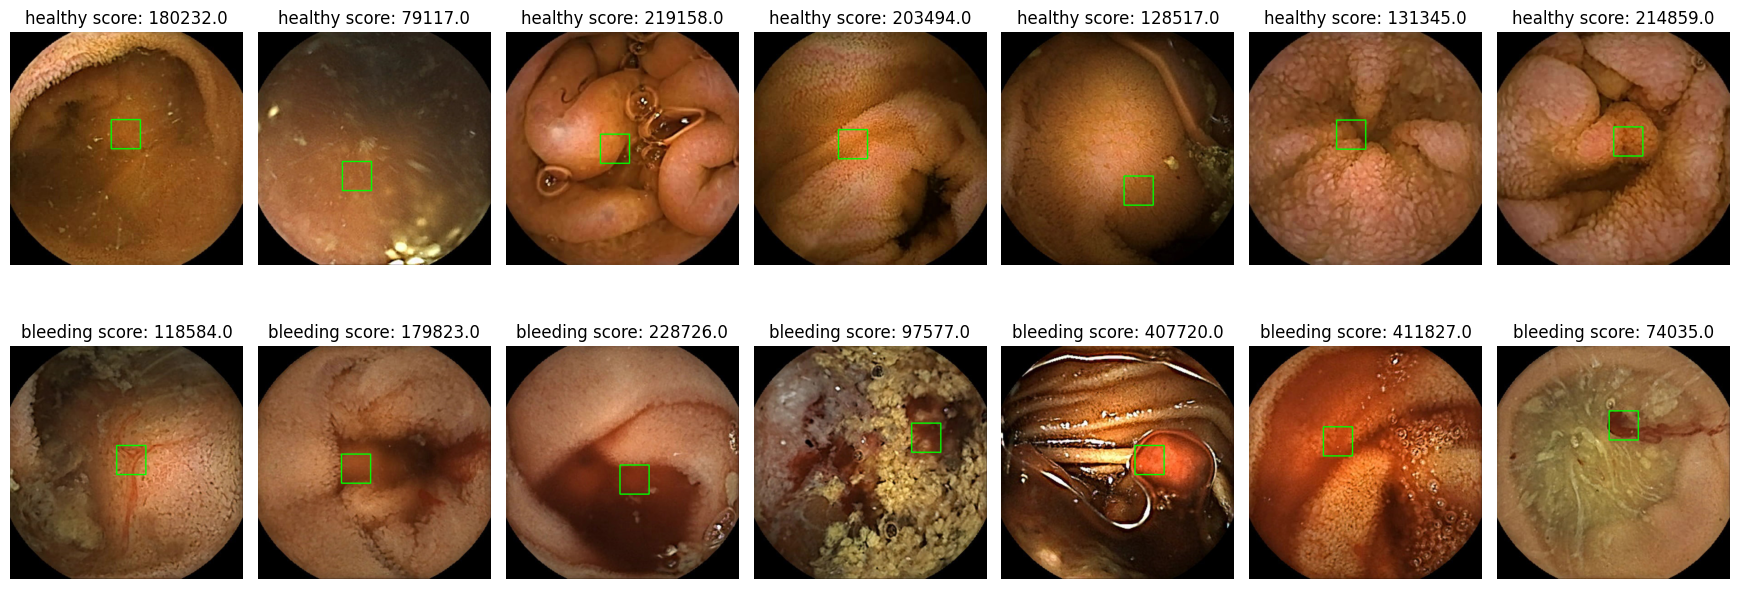

In [121]:
post_process = find_reddish_area
post_process_parameters = (64, 1, -1, -1, 20)
sample_count = 7
zero_indices = [i for i, x in enumerate(labels) if x == 0]
one_indices = [i for i, x in enumerate(labels) if x == 1]

healthy_indices = random.sample(zero_indices, sample_count)
healthy_images = [train_validation_dataset[i][0] for i in healthy_indices]
healthy_images = [torch_tensor_to_RGB_numpy(image) for image in healthy_images]
healthy_images = [post_process(image, *post_process_parameters) for image in healthy_images]

bleeding_indices = random.sample(one_indices, sample_count)
bleeding_images = [train_validation_dataset[i][0] for i in bleeding_indices]
bleeding_images = [torch_tensor_to_RGB_numpy(image) for image in bleeding_images]
bleeding_images = [post_process(image, *post_process_parameters) for image in bleeding_images]

fig, axes = plt.subplots(2, sample_count, figsize=(sample_count*2.5, sample_count))

images_and_scores = healthy_images + bleeding_images
images = [im[0] for im in images_and_scores]
scores = [im[1] for im in images_and_scores]
image_labels = [0 for _ in range(sample_count)] + [1 for _ in range(sample_count)]

for e, (ax, image, label) in enumerate(zip(axes.flat, images, image_labels)):
    ax.imshow(image)  # Display the image
    title = {0:'healthy', 1:'bleeding'}
    ax.set_title(f"{title[label]} score: {scores[e%sample_count + sample_count * (e//sample_count)]}")  # Add title with label
    ax.axis('off')  # Hide the axes for better visualization

plt.tight_layout()
plt.show()

In [126]:
def try_out_parameters(parameters, stop=100):
    predictions = []
    for e, (image, _) in tqdm(enumerate(train_validation_dataloader)):
        if e == stop:
            break
        np_image = image.detach().cpu().numpy()[0]
        decision = decision_function(np_image, *parameters)
        predictions.append(decision)

    colors = ['red' if label == 1 else 'green' for label in labels[:stop]]

    plt.figure(figsize=(30, 15))
    plt.scatter(range(len(predictions)), predictions, c=colors, linewidths=1.5, s=100)

    if THRESHOLD != 0.5:
        plt.axhline(y=THRESHOLD, color='blue', linestyle='--', label=f'THTHRESHOLD = {THRESHOLD}')
    plt.title(f"{decision_function.__name__} results with {parameters}", fontsize=20)
    plt.ylabel(f"{decision_function.__name__} output scale", fontsize=20)

    plt.scatter([], [], c='green', edgecolors='none', s=100, label='Healthy (green)')
    plt.scatter([], [], c='red', edgecolors='none', s=100, label='Bleeding (red)')
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

In [ ]:
try_out_parameters([10,50,5], 1000)

In [ ]:
try_out_parameters([10,100,10], 100)

In [ ]:
try_out_parameters([50,15,10], 100)

## Find Best Generalizing Parameters (try out different parameter combinations on train_validation_dataset, and select the best one to try on test dataset)

In [ ]:
parameter1_values = [1]
parameter2_values = [2]
parameter3_values = [3]
parameter_combinations = list(itertools.product(parameter1_values, parameter2_values, parameter3_values))

In [12]:
def save_prediction_plot(predictions, par_comb, total_acc, healthy_acc, bleeding_acc):
    colors = ['red' if label == 1 else 'green' for label in labels]
    outlines = ['black' if label != pred else 'none' for label, pred in zip(labels, predictions)]

    plt.figure(figsize=(30, 15))
    plt.scatter(range(len(predictions)), predictions, c=colors, edgecolors=outlines, linewidths=1.5, s=100)

    plt.axhline(y=THRESHOLD, color='blue', linestyle='--', label=f'THTHRESHOLD = {THRESHOLD}')
    plt.title(f"{decision_function.__name__} results with {par_comb} are total: {total_acc}, healthy: {healthy_acc}, bleeding: {bleeding_acc}", fontsize=20)
    plt.ylabel(f"{decision_function.__name__} output scale", fontsize=20)

    plt.scatter([], [], c='green', edgecolors='none', s=100, label='Healthy (green)')
    plt.scatter([], [], c='red', edgecolors='none', s=100, label='Bleeding (red)')
    plt.scatter([], [], c='none', edgecolors='black', s=100, label='Wrong Prediction (black outline)')
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.savefig(os.path.join(decision_function_path, f"{decision_function.__name__} results with {par_comb}.png"))

In [13]:
total_accuracies = []
healthy_accuracies = []
bleeding_accuracies = []
best_accuracy = 0
best_parameter_combination = None
parameter_decisions = []

In [ ]:
for par_comb in parameter_combinations:
    # class_correct counts how many correct predictions for that label [corrects_for_label_0, corrects_for_label_1]
    # class_total counts how many predictions are there for that label [predictions_for_label_0, predictions_for_label_1]
    class_correct, class_total = [0,0], [0,0]

    parameter_decisions.append([])
    for image, label in tqdm(train_validation_dataloader):
        decision = decision_function(image, *par_comb)
        parameter_decisions[-1].append(decision)

        class_total[label] += 1
        if decision == label:
        # increase the correct prediction count for that label
            class_correct[label] += 1

    total_accuracy = sum(class_correct)/sum(class_total)
    healthy_accuracy = class_correct[0]/class_total[0]
    bleeding_accuracy = class_correct[1]/class_total[1]

    total_accuracies.append(total_accuracy)
    healthy_accuracies.append(healthy_accuracy)
    bleeding_accuracies.append(bleeding_accuracy)

    if total_accuracy > best_accuracy:
        best_accuracy = total_accuracy
        best_parameter_combination = par_comb
    
    save_prediction_plot(parameter_decisions[-1], par_comb, total_accuracy, healthy_accuracy, bleeding_accuracy)